In [1]:

import os

from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
import igraph as ig

from event import Event

from dotenv import load_dotenv

load_dotenv()

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "data" / "gold"
OUT_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

In [ ]:
def merge_nodes(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, taglist: list[str]) -> None:
    surviving_tag = taglist[0]
    for removed_tag in taglist[1:]:
        edges_df.loc[edges_df['source'] == removed_tag, 'source'] = surviving_tag
        edges_df.loc[edges_df['target'] == removed_tag, 'target'] = surviving_tag

    nodes_df.drop(index=taglist[1:], inplace=True)
    

def prune_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    def _prune_nodes(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return node_df[
            (node_df['name'].isin(edge_df['from']))
            | (node_df['name'].isin(edge_df['to']))
        ]
        
        
    def _prune_edges(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return edge_df[
            (edge_df['from'].isin(node_df['name']))
            & (edge_df['to'].isin(node_df['name']))
        ]

    while True:
        n = len(node_df)
        m = len(edge_df)
        node_df = _prune_nodes(node_df, edge_df)
        edge_df = _prune_edges(node_df, edge_df)
        if n == len(node_df) and m == len(edge_df):
            return node_df, edge_df
        
def build_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> ig.Graph:
    edge_tuples = list(zip(edge_df['from'], edge_df['to']))
    g = ig.Graph.TupleList(
        edge_tuples,
        directed=False,
        vertex_name_attr="name",
        weights=True,
    )
    for col in node_df.columns:
        if col != "name":
            g.vs[col] = node_df.set_index("name").loc[g.vs['name'], col].tolist()

    for col in edge_df.columns:
        if col not in ("from", "to"):
            g.es[col] = edge_df[col].tolist()
    
    return g

def get_community(g: ig.Graph) -> ig.VertexClustering:
    community_method = None
    try:
        cl = g.community_leiden(objective_function="modularity")
        community_method = "leiden"
    except Exception:
        cl = g.community_multilevel()  # Louvain
        community_method = "louvain"
    
    print(f"Community method used: {community_method}")
    return cl

def get_metrics(g: ig.Graph) -> pd.DataFrame:
    vcount = g.vcount()
    components = g.components()
    component_sizes = pd.Series([len(c) for c in components], name="size").to_frame()
    component_sizes["component_id"] = component_sizes.index
    component_sizes = component_sizes[["component_id","size"]].sort_values("size", ascending=False).reset_index(drop=True)
    
    comp_id_map = {}
    for cid, comp in enumerate(components):
        for vid in comp:
            comp_id_map[vid] = cid
    
    degree_all = g.degree()
    eigenvector = g.eigenvector_centrality()

    return pd.DataFrame({
        "id":                 g.vs["name"],
        "type":               g.vs["type"],
        "label": g.vs["label"],
        "degree":             degree_all,
        "eigenvector":        eigenvector,
        "component_id":       [comp_id_map[i] for i in range(vcount)],
    })
    
def top_n(df: pd.DataFrame, col: str, n: int = 10, node_types: list | None = None) -> pd.DataFrame:
    sub = df if node_types is None else df[df["type"].isin(node_types)]
    return sub.sort_values(col, ascending=False).head(n).reset_index(drop=True)


In [75]:
event_df = pd.read_pickle("full_event_df.pkl")
event_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012
...,...,...,...,...,...,...,...
114702,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN
114703,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN
114704,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN
114705,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN


In [76]:
edges_df = pd.read_parquet(EDGES_PATH_PARQUET)
nodes_df = pd.read_parquet(NODES_PATH_PARQUET)

In [77]:
# agregamos as autorias aos eventos

event_labeled_df = event_df.join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="prop_tag"
).rename(columns={'source': 'auth_camara_tag'}).join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="proc_tag"
).rename(columns={'source': 'auth_senado_tag'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_camara_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_camara_label'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_senado_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_senado_label'})
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República
...,...,...,...,...,...,...,...,...,...,...,...
114702,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN,CD:204355,NaN,JOSIAS MARIO DA VITORIA,NaN
114703,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN,CD:141531,NaN,RODRIGO BATISTA DE CASTRO,NaN
114704,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN,CD:204569,NaN,PABLO OLIVA SOUZA,NaN
114705,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN,CD:178881,NaN,ALUISIO GUIMARAES MENDES FILHO,NaN


In [78]:
# como agora temos uma fileira para cada autor, vamos manter apenas o primeiro (só precisamos saber de onde sai cada projeto)

event_labeled_df = event_labeled_df[event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].ne(
    event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].shift()
).any(axis=1)].reset_index(drop=True)

In [79]:
for col in event_labeled_df.columns:
    if col.endswith("_tag"):
        event_labeled_df[col] = event_labeled_df[col].str.strip().str.upper()

event_labeled_df = event_labeled_df.fillna('')

In [80]:
from_camara = (
    event_labeled_df['auth_camara_tag'].str.startswith("CD:")
    | (event_labeled_df['auth_senado_tag'] == "SE:2")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:5438",  # Comissão de Legislação Participativa
        "CO:2003",  # CCJC
        "CO:539426",  # CPI da Americanas
    ]))
    | (event_labeled_df['auth_camara_label'].str.startswith("Comissão Mista da MPV"))  # Todas começam na Câmara
)
from_senado = (
    event_labeled_df['auth_senado_tag'].str.startswith("SS:")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:78",  # Senado
        "CO:79",  # Comissão mista (na verdade o autor é o Sen. Jorginho Mello)
    ]))
    | (event_labeled_df['auth_senado_tag'].isin([
        "SE:7352398",  # CPI da Pandemia
        "SE:3947422",  # Comissão de direitos humanos do Senado 
    ]))
)
from_externo = ~(from_camara | from_senado)

event_labeled_df['origem'] = np.select(
    [from_camara, from_senado, from_externo],
    ['camara', 'senado', 'externo'],
    default='unknown'
)
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
114805,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
114806,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
114807,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
114808,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


In [81]:
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,Poder Executivo,Presidência da República,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
114805,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
114806,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
114807,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
114808,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


In [82]:
# Vamos certificar que os externos realmente são externos

event_labeled_df[event_labeled_df['origem'] == 'externo'][[c for c in event_labeled_df.columns if c.startswith("auth")]].value_counts()

auth_camara_tag  auth_senado_tag  auth_camara_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              auth_senado_label                                    
CO:253           SE:55126         Poder Executivo                                                                                                                                                                                                                                                                                                

Critérios para score de proposições:

(considerando que o caminho pode ser Câmara -> Senado ou Senado -> Câmara)

* Foi protocolada na primeira casa mas não chegou a comissão ou plenário: 0.0
* Chegou a comissão ou plenário na primeira casa: 0.25
* Aprovada na primeira casa: 0.5
* Chegou a comissão ou plenário na segunda casa: 0.75
* Aprovada na segunda casa (ou seja, remetida a sanção ou promulgação): 1.0

In [83]:

df = event_labeled_df
by_label = df.groupby('label', sort=False)
origem = by_label['origem'].first()
origem

label
MPV 1000/2020    externo
MPV 1001/2020    externo
MPV 1002/2020    externo
MPV 1003/2020    externo
MPV 1004/2020    externo
                  ...   
PLV 8/2023        camara
PLV 9/2020        camara
PLV 9/2021        camara
PLV 9/2022        camara
PLV 9/2023        camara
Name: origem, Length: 28081, dtype: object

In [84]:
is_mpv_pl = df['label'].str.startswith(('MPV','PL'))
is_pec = df['label'].str.startswith('PEC')
has_sancao = df['event'].eq(Event.REMETIDO_A_SANCAO).groupby(df['label']).any()
has_promulg = df['event'].eq(Event.REMETIDO_A_PROMULGACAO).groupby(df['label']).any()

In [85]:
presence = (
    df.assign(present=True)
      .pivot_table(index='label',
                   columns=['casa','event'],
                   values='present',
                   aggfunc='any',
                   fill_value=False)
)
presence

casa                     camara                                            \
event         Event.APRESENTADO Event.DISTRIBUIDO Event.RECEBIDO_COMISSAO   
label                                                                       
MPV 1000/2020              True              True                    True   
MPV 1001/2020              True              True                    True   
MPV 1002/2020              True              True                    True   
MPV 1003/2020              True              True                    True   
MPV 1004/2020              True              True                    True   
...                         ...               ...                     ...   
PLV 8/2023                 True             False                   False   
PLV 9/2020                 True             False                   False   
PLV 9/2021                 True             False                   False   
PLV 9/2022                 True             False                   False   
PLV 9/2023                 True             False                   False   

casa                                                                          \
event         Event.DESIGNADO_RELATOR_COMISSAO Event.RETIRADO_PAUTA_COMISSAO   
label                                                                          
MPV 1000/2020                            False                         False   
MPV 1001/2020                            False                         False   
MPV 1002/2020                            False                         False   
MPV 1003/2020                            False                         False   
MPV 1004/2020                            False                         False   
...                                        ...                           ...   
PLV 8/2023                               False                         False   
PLV 9/2020                               False                         False   
PLV 9/2021                               False                         False   
PLV 9/2022                               False                         False   
PLV 9/2023                               False                         False   

casa                                                                    \
event         Event.APROVADA_URGENCIA Event.DESIGNADO_RELATOR_PLENARIO   
label                                                                    
MPV 1000/2020                   False                             True   
MPV 1001/2020                   False                            False   
MPV 1002/2020                   False                            False   
MPV 1003/2020                   False                             True   
MPV 1004/2020                   False                             True   
...                               ...                              ...   
PLV 8/2023                      False                            False   
PLV 9/2020                      False                            False   
PLV 9/2021                      False                            False   
PLV 9/2022                      False                            False   
PLV 9/2023                      False                            False   

casa                                                            \
event         Event.REMETIDO_AO_SENADO Event.REMETIDO_A_SANCAO   
label                                                            
MPV 1000/2020                    False                   False   
MPV 1001/2020                    False                   False   
MPV 1002/2020                    False                   False   
MPV 1003/2020                     True                   False   
MPV 1004/2020                     True                   False   
...                                ...                     ...   
PLV 8/2023                       False                   False   
PLV 9/2020                       False                   False   
PLV 9/2021                       Fals

In [86]:
def P(house: str, event: Event) -> pd.Series:
    col = (house, event)
    return presence[col] if col in presence.columns else pd.Series(False, index=presence.index)


In [87]:
score_camara_externo = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('camara', Event.APROVADO_PLENARIO),  # 0.5
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [88]:
score_senado = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('senado', Event.APROVADO_PLENARIO),  # 0.5
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [89]:
scores = pd.DataFrame({
    'origem': origem,
    'score_camara_externo': score_camara_externo,
    'score_senado': score_senado,
})
scores['score'] = np.where(
    scores['origem'].isin(['camara','externo']),
    scores['score_camara_externo'],
    np.where(scores['origem'].eq('senado'), scores['score_senado'], np.nan)
)

In [90]:
labels_and_scores: list[dict] = (
    scores['score']
    .rename('score')
    .to_frame()
    .reset_index(names='label')
    .to_dict('records')
)

In [91]:
labels_and_scores_df = pd.DataFrame(labels_and_scores).set_index('label', drop=True)
labels_and_scores_df

,score
label,
MPV 1000/2020,0.25
MPV 1001/2020,0.25
MPV 1002/2020,0.25
MPV 1003/2020,0.75
MPV 1004/2020,0.75
...,...
PLV 8/2023,0.00
PLV 9/2020,0.00
PLV 9/2021,0.00


In [92]:
nodes_scored_df = nodes_df.join(labels_and_scores_df, on="label")
nodes_scored_df = nodes_scored_df.set_index('tag', drop=True)
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:55143,Tribunal de Justiça do Distrito Federal e Terr...,None,Ente,NaN
SE:9999990,Superior Tribunal de Justiça,None,Ente,NaN
SE:9999991,Procuradoria-Geral da República,None,Ente,NaN


In [93]:
edges_df

,source,target,etype
0,CD:160655,CP:538196,autoria
1,CD:141488,CP:559138,autoria
2,CD:73584,CP:593065,autoria
3,CD:160518,CP:601739,autoria
4,CD:151208,CP:614512,autoria
...,...,...,...
51527,CO:382,SE:55143,correspondencia
51528,CO:101347,SE:9999991,correspondencia
51529,CO:57,SE:9999992,correspondencia
51530,CO:101131,SE:9999994,correspondencia


In [94]:
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:55143,Tribunal de Justiça do Distrito Federal e Terr...,None,Ente,NaN
SE:9999990,Superior Tribunal de Justiça,None,Ente,NaN
SE:9999991,Procuradoria-Geral da República,None,Ente,NaN


In [95]:
edges_df

,source,target,etype
0,CD:160655,CP:538196,autoria
1,CD:141488,CP:559138,autoria
2,CD:73584,CP:593065,autoria
3,CD:160518,CP:601739,autoria
4,CD:151208,CP:614512,autoria
...,...,...,...
51527,CO:382,SE:55143,correspondencia
51528,CO:101347,SE:9999991,correspondencia
51529,CO:57,SE:9999992,correspondencia
51530,CO:101131,SE:9999994,correspondencia


In [96]:
from collections import defaultdict

ccs: dict[str, set] = defaultdict(set)

for index, row in edges_df[edges_df['etype'].eq('correspondencia')].iterrows():
    src = row['source']
    tgt = row['target']
    src_set = ccs[src]
    tgt_set = ccs[tgt]
    new_set = {src, tgt}
    if not src_set and not tgt_set:
        ccs[src] = new_set
        ccs[tgt] = new_set
    elif not src_set:
        tgt_set.update(new_set)    
        ccs[src] = tgt_set
    else:  # no tgt_set
        src_set.update(new_set)
        ccs[tgt] = src_set
    

In [97]:
unique_ccs = {frozenset(s) for s in ccs.values()}

In [98]:
nodes_to_merge = [sorted(s) for s in unique_ccs]


In [99]:
edges_auth_df = edges_df[edges_df['etype'].eq('autoria')].drop(['etype'], axis=1).copy()

In [100]:
for taglist in nodes_to_merge:
    merge_nodes(nodes_scored_df, edges_auth_df, taglist)

In [101]:
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:7352398,CPI da Pandemia,None,Ente,NaN
SE:55226,Comissão Diretora,None,Ente,NaN
SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Ente,NaN


In [102]:
edges_weighted_df = edges_auth_df.join(nodes_scored_df[['score']], on="target").rename(columns={'score': 'weight'})

In [103]:
edge_df = edges_weighted_df.rename(columns={'source': 'from', 'target': 'to'})
edge_df.head()

,from,to,weight
0,CD:160655,CP:538196,1.00
1,CD:141488,CP:559138,1.00
2,CD:73584,CP:593065,1.00
3,CD:160518,CP:601739,0.25
4,CD:151208,CP:614512,1.00


In [104]:
node_df = nodes_scored_df.reset_index().rename(columns={'tag': 'name'})
node_df.head()

,name,label,partido,type,score
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00
1,CP:2190408,PL 2/2019,None,Proposicao,0.25
2,CP:2190417,PL 10/2019,None,Proposicao,0.25
3,CP:2190423,PL 15/2019,None,Proposicao,0.00
4,CP:2190450,PL 21/2019,None,Proposicao,0.25


In [105]:


node_df, edge_df = prune_graph(node_df, edge_df)

In [106]:
# Finalmente, a partir deste ponto não existe mais diferença entre um órgão ou ente (nomes diferentes para a mesma coisa)
node_df.loc[node_df['type'] == "Ente", 'type'] = 'Orgao'

In [107]:
node_df.value_counts('type')

type
Proposicao    27046
Processo       1113
Deputado        916
Senador         129
Orgao            46
Name: count, dtype: int64

In [151]:
type_to_bigtype = {
    'Proposicao': 'bill',
    'Processo': 'bill',
    'Orgao': 'author',
    'Deputado': 'author',
    'Senador': 'author',
}

node_df['bigtype'] = node_df['type'].map(type_to_bigtype)
node_df.value_counts('bigtype')

bigtype
bill      28159
author     1091
Name: count, dtype: int64

# Análises

## Escore médio por autor (mais simples)

In [152]:
author_mean_scores = (edge_df.groupby('from', as_index=False)['weight'].mean().rename(
    columns={'from': 'author', 'weight': 'mean_score'}  # type: ignore
).set_index('author', drop=True))
author_mean_scores

,mean_score
author,
CD:100689,0.250000
CD:103758,0.232143
CD:104552,0.235294
CD:105534,0.250000
CD:107283,0.272727
...,...
SS:751,0.350000
SS:825,0.345982
SS:878,0.250000


In [153]:
author_bill_counts = edge_df['from'].value_counts().rename_axis('name').reset_index(name='from_count').set_index('name', drop=True)

In [154]:
author_performance_df = node_df.join(author_mean_scores, on="name", how="inner").drop("score", axis=1).join(author_bill_counts, on="name", how="inner").set_index('name', drop=True)
author_performance_df

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,author,0.241379,58
CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,author,0.250000,2
CD:73472,GERVÁSIO JOSÉ DA SILVA,None,Deputado,author,0.250000,1
CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,author,0.205660,265
CD:73545,EUSTÁQUIO LUCIANO ZICA,None,Deputado,author,1.000000,1
...,...,...,...,...,...,...
SE:7352398,CPI da Pandemia,None,Orgao,author,0.550000,5
SE:55226,Comissão Diretora,None,Orgao,author,0.750000,2
SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,author,0.375000,6


In [155]:
# "Melhores" deputados
author_performance_df[author_performance_df['type'].eq("Deputado")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CD:73653,WELLINGTON ANTONIO FAGUNDES,None,Deputado,author,1.000000,1
CD:73454,JOÃO BATISTA DOS SANTOS,None,Deputado,author,1.000000,1
CD:131085,Olavo Bilac Pereira Pinto,None,Deputado,author,1.000000,1
CD:160649,ESPERIDIÃO AMIN HELOU FILHO,PP/SC,Deputado,author,1.000000,1
CD:160644,ESMERINO NERI BATISTA FILHO,None,Deputado,author,1.000000,1
...,...,...,...,...,...,...
CD:222429,LUIS CARLOS GOMES DA SILVA,REPUBLICANOS/RJ,Deputado,author,0.083333,3
CD:214477,RENATO ANDRADE QUEIROZ,MDB/RR,Deputado,author,0.083333,3
CD:220661,MATHEUS SOARES NORONHA,PL/CE,Deputado,author,0.000000,1


In [156]:
# "Melhores" senadores
author_performance_df[author_performance_df['type'].eq("Senador")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
SS:5740,Fabio Garcia,None,Senador,author,0.875000,2
SS:4642,Efraim Filho,UNIÃO/PB,Senador,author,0.785714,7
SS:4639,Beto Faro,PT/PA,Senador,author,0.750000,2
SS:5996,Diego Tavares,None,Senador,author,0.750000,1
SS:5386,Professora Dorinha Seabra,UNIÃO/TO,Senador,author,0.750000,3
...,...,...,...,...,...,...
SS:5971,Prisco Bezerra,None,Senador,author,0.250000,1
SS:5008,Humberto Costa,PT/PE,Senador,author,0.240909,55
SS:677,Roberto Rocha,None,Senador,author,0.238889,45


In [157]:
# "Melhores" órgãos ou entes
author_performance_df[author_performance_df['type'].eq("Orgao")].sort_values("mean_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count
name,,,,,,
CO:4,Mesa Diretora da Câmara dos Deputados,None,Orgao,author,1.000000,2
CO:6066,Comissão de Turismo,None,Orgao,author,1.000000,1
CO:538490,Comissão especial destinada a acompanhar as aç...,None,Orgao,author,1.000000,1
CO:100292,CÂMARA DOS DEPUTADOS,None,Orgao,author,0.953552,366
CO:101347,Procuradoria-Geral da República,None,Orgao,author,0.950000,5
CO:57,MINISTÉRIO PÚBLICO DA UNIÃO,None,Orgao,author,0.916667,9
CO:81,Superior Tribunal de Justiça,None,Orgao,author,0.900000,5
CO:101131,Defensoria Pública da União,None,Orgao,author,0.850000,10
CO:382,Tribunal de Justiça do Distrito Federal e dos ...,None,Orgao,author,0.833333,9


Vemos que acabam sendo privilegiados parlamentares/órgãos que participaram de poucos projetos bem-sucedidos. Vamos penalizar por número de tentativas.

In [158]:
means_by_type = {
    t: author_performance_df[author_performance_df['type'].eq(t)]['from_count'].mean()
    for t in author_performance_df['type'].unique()
}
means_by_type

{'Deputado': np.float64(47.012008733624455),
 'Orgao': np.float64(60.73913043478261),
 'Senador': np.float64(30.891472868217054)}

In [159]:
author_performance_df['concave_score'] = (
    author_performance_df['mean_score']
    * author_performance_df['from_count'] / (author_performance_df['from_count'] + author_performance_df['type'].apply(lambda v: means_by_type[v])))

In [160]:
# "Melhores" deputados
author_performance_df[author_performance_df['type'].eq("Deputado")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
CD:141470,JOSÉ NOBRE GUIMARÃES,PT/CE,Deputado,author,0.287273,275,0.245332
CD:74398,MARIA DO ROSÁRIO NUNES,PT/RS,Deputado,author,0.292601,223,0.241656
CD:204503,ALEXANDRE ROCHA SANTOS PADILHA,PT/SP,Deputado,author,0.294737,190,0.236275
CD:73701,BENEDITA SOUZA DA SILVA SAMPAIO,PT/RJ,Deputado,author,0.288770,187,0.230757
CD:204467,ROSA NEIDE SANDES DE ALMEIDA,PT/MT,Deputado,author,0.270213,235,0.225168
...,...,...,...,...,...,...,...
CD:141518,PAULO PEREIRA DA SILVA,SOLIDARIEDADE/SP,Deputado,author,0.083333,3,0.004999
CD:214477,RENATO ANDRADE QUEIROZ,MDB/RR,Deputado,author,0.083333,3,0.004999
CD:220661,MATHEUS SOARES NORONHA,PL/CE,Deputado,author,0.000000,1,0.000000


In [161]:
# "Melhores" senadores
author_performance_df[author_performance_df['type'].eq("Senador")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
SS:345,Flávio Arns,PSB/PR,Senador,author,0.506494,77,0.361474
SS:1173,Wellington Fagundes,PL/MT,Senador,author,0.579545,44,0.340493
SS:5748,Veneziano Vital do Rêgo,MDB/PB,Senador,author,0.468750,80,0.338168
SS:5985,Nelsinho Trad,PSD/MS,Senador,author,0.478070,57,0.310041
SS:22,Esperidião Amin,PP/SC,Senador,author,0.463710,62,0.309501
...,...,...,...,...,...,...,...
SS:611,Chiquinho Feitosa,None,Senador,author,0.750000,1,0.023517
SS:5913,Rafael Tenório,None,Senador,author,0.750000,1,0.023517
SS:6363,Rosana Martinelli,None,Senador,author,0.250000,1,0.007839


In [162]:
# "Melhores" orgaos
author_performance_df[author_performance_df['type'].eq("Orgao")].sort_values("concave_score", ascending=False)

,label,partido,type,bigtype,mean_score,from_count,concave_score
name,,,,,,,
CO:100292,CÂMARA DOS DEPUTADOS,None,Orgao,author,0.953552,366,0.817830
CO:78,Senado Federal,None,Orgao,author,0.751398,894,0.703595
CO:253,Poder Executivo,None,Orgao,author,0.728618,1368,0.697643
CO:101131,Defensoria Pública da União,None,Orgao,author,0.850000,10,0.120160
CO:57,MINISTÉRIO PÚBLICO DA UNIÃO,None,Orgao,author,0.916667,9,0.118298
CO:382,Tribunal de Justiça do Distrito Federal e dos ...,None,Orgao,author,0.833333,9,0.107544
CO:80,Supremo Tribunal Federal,None,Orgao,author,0.777778,9,0.100374
CO:5438,Comissão de Legislação Participativa,None,Orgao,author,0.225610,41,0.090919
CO:101347,Procuradoria-Geral da República,None,Orgao,author,0.950000,5,0.072255


Tudo isso é subjetivo e senende da nossa definição de sucesso, é claro. Vamos tentar uma abordagem por grafo.
Vamos verificar a centralidade por autovetores, usando o score das proposições como pesos nas arestas.

In [ ]:

g = build_graph(node_df, edge_df)
vertex_metrics = get_metrics(g)
top10_deps_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Orgao"])


In [164]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:204467,Deputado,ROSA NEIDE SANDES DE ALMEIDA,235,1.000000,0
1,CD:178970,Deputado,JOAO SOMARIVA DANIEL,259,0.990819,0
2,CD:178986,Deputado,NILTO IGNACIO TATTO,253,0.986212,0
3,CD:74160,Deputado,PATRUS ANANIAS DE SOUZA,199,0.983678,0
4,CD:160535,Deputado,DIONILSO MATEUS MARCON,183,0.977666,0
5,CD:204393,Deputado,ANTONIO RIBEIRO,202,0.953556,0
6,CD:160610,Deputado,VALMIR CARLOS DA ASSUNÇÃO,195,0.950399,0
7,CD:204555,Deputado,JOSÉ RICARDO WENDLING,186,0.944515,0
8,CD:204480,Deputado,ROGÉRIO CORREIA DE MOURA BAPTISTA,191,0.937939,0
9,CD:204370,Deputado,CELIO ALVES DE MOURA,158,0.927105,0


In [165]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:345,Senador,Flávio Arns,77,0.000003,0
1,SS:5748,Senador,Veneziano Vital do Rêgo,80,0.000003,0
2,SS:825,Senador,Paulo Paim,112,0.000003,0
3,SS:5895,Senador,Jorge Kajuru,79,0.000002,0
4,SS:22,Senador,Esperidião Amin,62,0.000002,0
5,SS:5985,Senador,Nelsinho Trad,57,0.000002,0
6,SS:5979,Senador,Leila Barros,67,0.000002,0
7,SS:1173,Senador,Wellington Fagundes,44,0.000002,0
8,SS:5953,Senador,Fabiano Contarato,63,0.000002,0
9,SS:475,Senador,Confúcio Moura,70,0.000002,0


In [166]:
top10_orgs_eigen

,id,type,label,degree,eigenvector,component_id
0,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,366,9.385529e-02,0
1,CO:78,Orgao,Senado Federal,894,2.939004e-04,0
2,CO:4,Orgao,Mesa Diretora da Câmara dos Deputados,2,4.036418e-05,0
3,CO:538490,Orgao,Comissão especial destinada a acompanhar as aç...,1,2.017775e-05,0
4,CO:6066,Orgao,Comissão de Turismo,1,2.017775e-05,0
5,SE:7352398,Orgao,CPI da Pandemia,5,1.897182e-07,0
6,SE:3947422,Orgao,Comissão de Direitos Humanos e Legislação Part...,6,1.265060e-07,0
7,SE:3927825,Orgao,Comissão de Meio Ambiente,2,1.263972e-07,0
8,SE:55226,Orgao,Comissão Diretora,2,1.263972e-07,0
9,CO:253,Orgao,Poder Executivo,1368,1.996472e-13,6


## Análises por tipo de proposição

Entendemos que PLs, PECs e MPs têm naturezas muito diferentes e faria mais sentido analisá-las em separado

In [167]:
node_df.shape, edge_df.shape

((29250, 6), (49842, 3))

In [168]:
pl_node_df = node_df[(node_df['label'].str.startswith("PL"))|(node_df['bigtype'].ne('bill'))].copy()
pl_node_df, pl_edge_df = prune_graph(pl_node_df, edge_df.copy())
pl_node_df


,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29244,SS:6295,Carlos Fávaro,None,Senador,NaN,author
29245,SE:7352398,CPI da Pandemia,None,Orgao,NaN,author
29246,SE:55226,Comissão Diretora,None,Orgao,NaN,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,NaN,author


In [169]:
pl_g = build_graph(pl_node_df, pl_edge_df)
pl_vertex_metrics = get_metrics(pl_g)
top10_deps_eigen = top_n(pl_vertex_metrics, "eigenvector", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(pl_vertex_metrics, "eigenvector", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(pl_vertex_metrics, "eigenvector", 10, node_types=["Orgao"])

In [170]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:204467,Deputado,ROSA NEIDE SANDES DE ALMEIDA,234,1.000000,0
1,CD:178986,Deputado,NILTO IGNACIO TATTO,250,0.984850,0
2,CD:74160,Deputado,PATRUS ANANIAS DE SOUZA,197,0.982613,0
3,CD:178970,Deputado,JOAO SOMARIVA DANIEL,251,0.981983,0
4,CD:160535,Deputado,DIONILSO MATEUS MARCON,181,0.974786,0
5,CD:160610,Deputado,VALMIR CARLOS DA ASSUNÇÃO,195,0.957969,0
6,CD:204393,Deputado,ANTONIO RIBEIRO,201,0.953743,0
7,CD:204555,Deputado,JOSÉ RICARDO WENDLING,184,0.944176,0
8,CD:141488,Deputado,LUIZ PAULO TEIXEIRA FERREIRA,229,0.933184,0
9,CD:204480,Deputado,ROGÉRIO CORREIA DE MOURA BAPTISTA,187,0.931555,0


In [171]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:2331,Senador,Rose de Freitas,163,1.248548e-15,10
1,SS:345,Senador,Flávio Arns,43,9.615246e-16,10
2,SS:825,Senador,Paulo Paim,65,9.128112e-16,10
3,SS:5748,Senador,Veneziano Vital do Rêgo,46,8.769731e-16,10
4,SS:5352,Senador,Rogério Carvalho,73,7.150908e-16,10
5,SS:1173,Senador,Wellington Fagundes,29,6.765448e-16,10
6,SS:5895,Senador,Jorge Kajuru,37,5.989884e-16,10
7,SS:5979,Senador,Leila Barros,30,5.922588e-16,10
8,SS:5376,Senador,Mara Gabrilli,35,5.881175e-16,10
9,SS:22,Senador,Esperidião Amin,23,5.450851e-16,10


In [172]:
top10_orgs_eigen

,id,type,label,degree,eigenvector,component_id
0,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,359,9.222008e-02,0
1,CO:4,Orgao,Mesa Diretora da Câmara dos Deputados,2,4.015496e-05,0
2,CO:538490,Orgao,Comissão especial destinada a acompanhar as aç...,1,2.007311e-05,0
3,CO:6066,Orgao,Comissão de Turismo,1,2.007311e-05,0
4,CO:78,Orgao,Senado Federal,856,2.193317e-14,10
5,CO:253,Orgao,Poder Executivo,600,2.143621e-14,9
6,CO:5438,Orgao,Comissão de Legislação Participativa,41,1.006809e-16,24
7,SE:7352398,Orgao,CPI da Pandemia,5,7.917247e-17,10
8,SE:3947422,Orgao,Comissão de Direitos Humanos e Legislação Part...,6,5.693954e-17,10
9,SE:55226,Orgao,Comissão Diretora,2,4.994446e-17,10


In [173]:
pec_node_df = node_df[(node_df['label'].str.startswith("PEC"))|(node_df['bigtype'].ne('bill'))].copy()
pec_node_df, pec_edge_df = prune_graph(pec_node_df, edge_df.copy())
pec_g = build_graph(pec_node_df, pec_edge_df)
pec_vertex_metrics = get_metrics(pec_g)
top10_deps_eigen = top_n(pec_vertex_metrics, "eigenvector", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(pec_vertex_metrics, "eigenvector", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(pec_vertex_metrics, "eigenvector", 10, node_types=["Orgao"])

In [174]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:133439,Deputado,ANDRÉ PEIXOTO FIGUEIREDO LIMA,9,0.000342,0
1,CD:74043,Deputado,JOSÉ WELLINGTON ROBERTO,6,0.000340,0
2,CD:74262,Deputado,CARLOS HENRIQUE FOCESI SAMPAIO,9,0.000340,0
3,CD:160632,Deputado,JOSÉ SILVA SOARES,6,0.000337,0
4,CD:204468,Deputado,JOENIA BATISTA DE CARVALHO,4,0.000336,0
5,CD:204537,Deputado,ENRICO VAN BLARCUM DE GRAAFF MISASI,4,0.000336,0
6,CD:178975,Deputado,LUIZ FELIPE BALEIA TENUTO ROSSI,7,0.000336,0
7,CD:160510,Deputado,LUIS HENRIQUE DE OLIVEIRA RESENDE,3,0.000334,0
8,CD:178925,Deputado,REJANE RIBEIRO SOUSA DIAS,3,0.000333,0
9,CD:74693,Deputado,RODRIGO FELINTO IBARRA EPITÁCIO MAIA,2,0.000332,0


In [175]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:5502,Senador,Plínio Valério,53,0.851940,0
1,SS:825,Senador,Paulo Paim,47,0.786774,0
2,SS:5895,Senador,Jorge Kajuru,42,0.691782,0
3,SS:5985,Senador,Nelsinho Trad,42,0.686292,0
4,SS:945,Senador,Alvaro Dias,39,0.657006,0
5,SS:22,Senador,Esperidião Amin,39,0.651750,0
6,SS:5533,Senador,Lasier Martins,38,0.647807,0
7,SS:5979,Senador,Leila Barros,37,0.628767,0
8,SS:4770,Senador,Izalci Lucas,37,0.591390,0
9,SS:5959,Senador,Styvenson Valentim,35,0.583728,0


In [176]:
top10_orgs_eigen

,id,type,label,degree,eigenvector,component_id
0,CO:78,Orgao,Senado Federal,38,2.937163e-01,0
1,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,7,6.609052e-04,0
2,CO:253,Orgao,Poder Executivo,5,3.012479e-18,3


(para medidas provisórias, é claro, esta análise não cabe, pois a autoria é sempre do Poder Executivo)

## Análise por casa legislativa

In [177]:
dep_node_df = node_df[(node_df['name'].str.startswith("CD:"))|(node_df['bigtype'].ne('author'))].copy()
dep_node_df, dep_edge_df = prune_graph(dep_node_df, edge_df.copy())
dep_g = build_graph(dep_node_df, dep_edge_df)
dep_vertex_metrics = get_metrics(dep_g)
top10_deps_eigen = top_n(dep_vertex_metrics, "eigenvector", 10, node_types=["Deputado"])

In [178]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:204467,Deputado,ROSA NEIDE SANDES DE ALMEIDA,235,1.000000,0
1,CD:178970,Deputado,JOAO SOMARIVA DANIEL,259,0.990991,0
2,CD:178986,Deputado,NILTO IGNACIO TATTO,253,0.986403,0
3,CD:74160,Deputado,PATRUS ANANIAS DE SOUZA,199,0.983886,0
4,CD:160535,Deputado,DIONILSO MATEUS MARCON,183,0.977834,0
5,CD:204393,Deputado,ANTONIO RIBEIRO,202,0.953758,0
6,CD:160610,Deputado,VALMIR CARLOS DA ASSUNÇÃO,195,0.950601,0
7,CD:204555,Deputado,JOSÉ RICARDO WENDLING,186,0.944690,0
8,CD:204480,Deputado,ROGÉRIO CORREIA DE MOURA BAPTISTA,191,0.938111,0
9,CD:204370,Deputado,CELIO ALVES DE MOURA,158,0.927276,0


In [179]:
sen_node_df = node_df[(node_df['name'].str.startswith("SS:"))|(node_df['bigtype'].ne('author'))].copy()
sen_node_df, sen_edge_df = prune_graph(sen_node_df, edge_df.copy())
sen_g = build_graph(sen_node_df, sen_edge_df)
sen_vertex_metrics = get_metrics(sen_g)
top10_sens_eigen = top_n(sen_vertex_metrics, "eigenvector", 10, node_types=["Senador"])

In [180]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:825,Senador,Paulo Paim,112,0.865684,0
1,SS:5502,Senador,Plínio Valério,64,0.862558,0
2,SS:5895,Senador,Jorge Kajuru,79,0.714343,0
3,SS:5985,Senador,Nelsinho Trad,57,0.701168,0
4,SS:2331,Senador,Rose de Freitas,197,0.687008,0
5,SS:945,Senador,Alvaro Dias,82,0.683666,0
6,SS:22,Senador,Esperidião Amin,62,0.677499,0
7,SS:5533,Senador,Lasier Martins,71,0.665345,0
8,SS:5979,Senador,Leila Barros,67,0.647556,0
9,SS:4770,Senador,Izalci Lucas,63,0.620354,0


# Análise por comunidade

In [182]:
g.vs['bigtype_bool'] = [t == 'author' for t in g.vs['bigtype']]

In [201]:
g_bill, g_auth = g.bipartite_projection(
    types='bigtype_bool',
    multiplicity=True,  # queremos + arestas por parceria
)

In [204]:
g_auth.vs['score'][:10]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [195]:
cl = get_community(g_auth)

Community method used: leiden


In [196]:
cl.modularity

0.2814171702389994

In [241]:
vertex_metrics = get_metrics(g_auth)
top10_deps_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Orgao"])

In [242]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:204572,Deputado,ALBERTO BARROS CAVALCANTE NETO,614,1.000000,0
1,CD:204412,Deputado,ZACARIAS CALIL HAMU,599,0.999806,0
2,CD:178947,Deputado,SOSTENES SILVA CAVALCANTE,603,0.994988,0
3,CD:98057,Deputado,LAFAYETTE LUIZ DOORGAL DE ANDRADA,590,0.994400,0
4,CD:204374,Deputado,BEATRIZ KICIS TORRENTS DE SORDI,595,0.983672,0
5,CD:74467,Deputado,DAMIÃO FELICIANO DA SILVA,579,0.975944,0
6,CD:74161,Deputado,REGINALDO LÁZARO DE OLIVEIRA LOPES,585,0.961025,0
7,CD:204511,Deputado,DAVID BEZERRA RIBEIRO SOARES,557,0.954634,0
8,CD:133439,Deputado,ANDRÉ PEIXOTO FIGUEIREDO LIMA,593,0.944840,0
9,CD:160575,Deputado,ÉRIKA JUCÁ KOKAY,576,0.942278,0


In [243]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:5502,Senador,Plínio Valério,120,0.000095,0
1,SS:22,Senador,Esperidião Amin,119,0.000095,0
2,SS:6027,Senador,Mecias de Jesus,116,0.000095,0
3,SS:5985,Senador,Nelsinho Trad,115,0.000095,0
4,SS:470,Senador,Chico Rodrigues,117,0.000095,0
5,SS:5976,Senador,Eduardo Girão,116,0.000095,0
6,SS:3777,Senador,Eduardo Gomes,116,0.000094,0
7,SS:4770,Senador,Izalci Lucas,114,0.000094,0
8,SS:3806,Senador,Zequinha Marinho,114,0.000094,0
9,SS:5523,Senador,Otto Alencar,111,0.000094,0


In [244]:
top10_orgs_eigen

,id,type,label,degree,eigenvector,component_id
0,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,484,0.731849,0
1,CO:78,Orgao,Senado Federal,143,0.021289,0
2,CO:538490,Orgao,Comissão especial destinada a acompanhar as aç...,1,0.002223,0
3,CO:4,Orgao,Mesa Diretora da Câmara dos Deputados,1,0.002223,0
4,CO:6066,Orgao,Comissão de Turismo,1,0.002223,0
5,SE:3927825,Orgao,Comissão de Meio Ambiente,1,0.000065,0
6,SE:55226,Orgao,Comissão Diretora,1,0.000065,0
7,SE:7352398,Orgao,CPI da Pandemia,1,0.000065,0
8,SE:3947422,Orgao,Comissão de Direitos Humanos e Legislação Part...,1,0.000065,0
9,CO:2014,Orgao,Comissão de Saúde,0,-0.000000,19


In [245]:
import pandas as pd
import igraph as ig
from itertools import combinations

def author_projection_sum_scores(edges_df: pd.DataFrame, nodes_df) -> ig.Graph:
    """
    Build an author-author projection where edge weight(i,j) = sum of scores of bills
    co-authored by i and j. Assumes 'weight' on each (author,bill) row equals the bill's score.
    """
    # ensure types
    df = edges_df[['from','to','weight']].copy()
    df['from'] = df['from'].astype(str)
    df['to']   = df['to'].astype(str)
    df['weight'] = df['weight'].astype(float)

    # Aggregate per bill: list authors and the bill's score (assumed constant within bill)
    per_bill = (df.groupby('to')
                  .agg(authors=('from', lambda s: sorted(pd.unique(s))),
                       score=('weight', 'first'))
                  .reset_index())

    # Build pair weights by summing scores over shared bills
    pair_rows: list[tuple[str,str,float]] = []
    for _, row in per_bill.iterrows():
        authors = row['authors']
        s = float(row['score'])
        if len(authors) >= 2:
            for a, b in combinations(authors, 2):
                pair_rows.append((a, b, s))

    if not pair_rows:
        # No co-authorships; return empty graph with isolated author nodes
        authors_all = df['from'].unique().tolist()
        g_auth = ig.Graph()
        g_auth.add_vertices(authors_all)
        g_auth.vs['name'] = authors_all
        return g_auth

    pair_df = pd.DataFrame(pair_rows, columns=['a','b','w']).groupby(['a','b'], as_index=False)['w'].sum()

    # Create igraph author-author weighted graph
    authors_all = pd.Index(pd.unique(df['from'])).tolist()
    name_to_vid = {name: i for i, name in enumerate(authors_all)}

    edges = [(name_to_vid[a], name_to_vid[b]) for a,b in pair_df[['a','b']].to_numpy()]
    weights = pair_df['w'].to_numpy().tolist()

    g_auth = ig.Graph(n=len(authors_all), edges=edges, directed=False)
    g_auth.vs['name'] = authors_all
    g_auth.vs['label'] = nodes_df.set_index('name').loc[authors_all, 'label']
    g_auth.vs['partido'] = nodes_df.set_index('name').loc[authors_all, 'partido']
    g_auth.vs['score'] = nodes_df.set_index('name').loc[authors_all, 'score']
    g_auth.vs['type'] = nodes_df.set_index('name').loc[authors_all, 'type']
    g_auth.es['weight'] = weights
    return g_auth


In [246]:
auth_score_g = author_projection_sum_scores(edge_df, node_df)

/tmp/ipykernel_2148443/644742665.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g_auth.vs['label'] = nodes_df.set_index('name').loc[authors_all, 'label']
/tmp/ipykernel_2148443/644742665.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g_auth.vs['partido'] = nodes_df.set_index('name').loc[authors_all, 'partido']
/tmp/ipykernel_2148443/644742665.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g_auth.vs['score'] = nodes

In [247]:
cl = get_community(auth_score_g)

Community method used: leiden


In [248]:
cl.modularity

0.2813291128131255

In [249]:
vertex_metrics = get_metrics(auth_score_g)
top10_deps_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Deputado"])
top10_sens_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Senador"])
top10_orgs_eigen = top_n(vertex_metrics, "eigenvector", 10, node_types=["Orgao"])

In [250]:
top10_deps_eigen

,id,type,label,degree,eigenvector,component_id
0,CD:204572,Deputado,ALBERTO BARROS CAVALCANTE NETO,614,1.000000,0
1,CD:204412,Deputado,ZACARIAS CALIL HAMU,599,0.999806,0
2,CD:178947,Deputado,SOSTENES SILVA CAVALCANTE,603,0.994988,0
3,CD:98057,Deputado,LAFAYETTE LUIZ DOORGAL DE ANDRADA,590,0.994400,0
4,CD:204374,Deputado,BEATRIZ KICIS TORRENTS DE SORDI,595,0.983672,0
5,CD:74467,Deputado,DAMIÃO FELICIANO DA SILVA,579,0.975944,0
6,CD:74161,Deputado,REGINALDO LÁZARO DE OLIVEIRA LOPES,585,0.961025,0
7,CD:204511,Deputado,DAVID BEZERRA RIBEIRO SOARES,557,0.954634,0
8,CD:133439,Deputado,ANDRÉ PEIXOTO FIGUEIREDO LIMA,593,0.944840,0
9,CD:160575,Deputado,ÉRIKA JUCÁ KOKAY,576,0.942278,0


In [251]:
top10_sens_eigen

,id,type,label,degree,eigenvector,component_id
0,SS:5502,Senador,Plínio Valério,120,0.000095,0
1,SS:22,Senador,Esperidião Amin,119,0.000095,0
2,SS:6027,Senador,Mecias de Jesus,116,0.000095,0
3,SS:5985,Senador,Nelsinho Trad,115,0.000095,0
4,SS:470,Senador,Chico Rodrigues,117,0.000095,0
5,SS:5976,Senador,Eduardo Girão,116,0.000095,0
6,SS:3777,Senador,Eduardo Gomes,116,0.000094,0
7,SS:4770,Senador,Izalci Lucas,114,0.000094,0
8,SS:3806,Senador,Zequinha Marinho,114,0.000094,0
9,SS:5523,Senador,Otto Alencar,111,0.000094,0


In [252]:
top10_orgs_eigen

,id,type,label,degree,eigenvector,component_id
0,CO:100292,Orgao,CÂMARA DOS DEPUTADOS,484,7.318485e-01,0
1,CO:78,Orgao,Senado Federal,143,2.128897e-02,0
2,CO:538490,Orgao,Comissão especial destinada a acompanhar as aç...,1,2.222520e-03,0
3,CO:4,Orgao,Mesa Diretora da Câmara dos Deputados,1,2.222520e-03,0
4,CO:6066,Orgao,Comissão de Turismo,1,2.222520e-03,0
5,SE:3927825,Orgao,Comissão de Meio Ambiente,1,6.465158e-05,0
6,SE:55226,Orgao,Comissão Diretora,1,6.465158e-05,0
7,SE:7352398,Orgao,CPI da Pandemia,1,6.465158e-05,0
8,SE:3947422,Orgao,Comissão de Direitos Humanos e Legislação Part...,1,6.465158e-05,0
9,CO:101582,Orgao,Tribunal de Contas da União,1,3.072667e-21,53


In [257]:
node_df

,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29245,SE:7352398,CPI da Pandemia,None,Orgao,NaN,author
29246,SE:55226,Comissão Diretora,None,Orgao,NaN,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,NaN,author
29248,SE:3927825,Comissão de Meio Ambiente,None,Orgao,NaN,author


In [299]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# g: your igraph.Graph with vertex attributes:
# - 'type' (str) -> node type
# - optional 'weight' on edges

def view_graph(g: ig.Graph):
    # 1) Layout + communities
    layout = g.layout_fruchterman_reingold(weights=g.es['weight'] if 'weight' in g.es.attributes() else None, niter=2000)
    coords = np.array(layout.coords)

    # Leiden communities (falls back if package not installed)
    try:
        comm = g.community_leiden(objective_function='modularity', weights=g.es['weight'] if 'weight' in g.es.attributes() else None)
    except Exception:
        comm = g.community_multilevel(weights=g.es['weight'] if 'weight' in g.es.attributes() else None)

    # 2) Colors by node type
    types = [v['type'] for v in g.vs]
    uniq_types = sorted(set(types))
    palette = plt.cm.get_cmap('tab10', len(uniq_types))
    color_map = {t: palette(i) for i, t in enumerate(uniq_types)}
    vcolors = [color_map[t] for t in types]

    # 3) Plot nodes & edges with matplotlib for full control
    fig, ax = plt.subplots(figsize=(10, 10))
    # edges
    for e in g.es:
        i, j = e.tuple
        ax.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], lw=0.4, alpha=0.25, zorder=1)

    # nodes
    ax.scatter(coords[:,0], coords[:,1], s=15, c=vcolors, edgecolors='white', linewidths=0.4, zorder=2)

    # 4) (Optional) draw translucent hulls per community
    for cid in range(len(comm)):
        members = np.array(comm.membership) == cid
        pts = coords[members]
        if pts.shape[0] >= 3:
            hull = ConvexHull(pts)
            poly = plt.Polygon(pts[hull.vertices], alpha=0.08, ec='none', fc='gray')
            ax.add_patch(poly)

    # 5) Legend for node types
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', markersize=8, markerfacecolor=color_map[t], markeredgecolor='white') for t in uniq_types]
    ax.legend(handles, uniq_types, frameon=False, loc='upper right', title='Node type')

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


In [300]:
node_df

,name,label,partido,type,score,bigtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill
...,...,...,...,...,...,...
29245,SE:7352398,CPI da Pandemia,None,Orgao,NaN,author
29246,SE:55226,Comissão Diretora,None,Orgao,NaN,author
29247,SE:3947422,Comissão de Direitos Humanos e Legislação Part...,None,Orgao,NaN,author
29248,SE:3927825,Comissão de Meio Ambiente,None,Orgao,NaN,author


In [301]:
house_node_df = node_df[(node_df['name'].str.startswith('CD:'))|(node_df['bigtype'].eq('bill'))]
house_node_df, house_edge_df = prune_graph(house_node_df, edge_df)
house_node_df.shape, house_edge_df.shape

((26190, 6), (43063, 3))

In [302]:
g = build_graph(house_node_df, house_edge_df)

/tmp/ipykernel_2148443/1534767078.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(uniq_types))


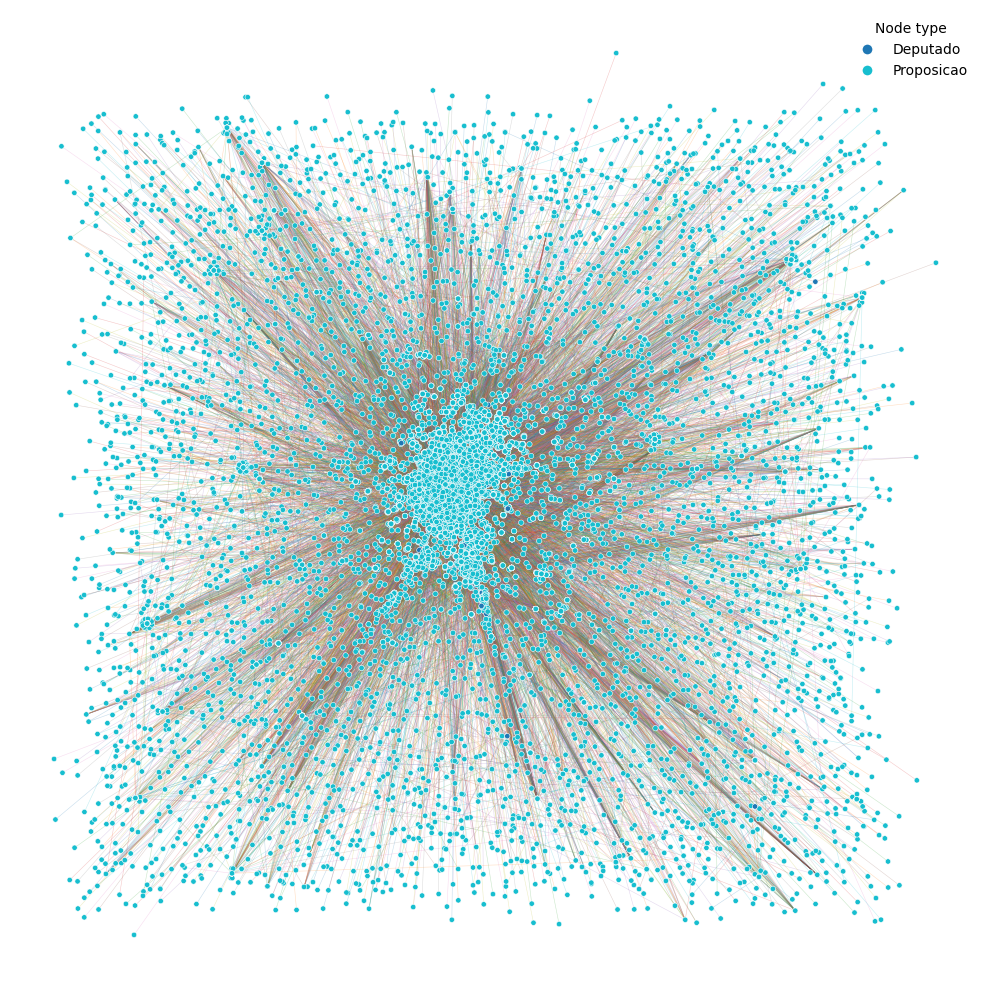

In [303]:
view_graph(g)